<a href="https://colab.research.google.com/github/MammadovN/Machine_Learning/blob/main/projects/01_supervised/anomaly_detection/fraud_detection/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd

# Load the data

df = pd.read_csv('/content/creditcard.csv')

# First 5 rows
print(df.head(10))

# Basic statistics
print(df.describe())

# Class distribution (Fraud/Non-Fraud ratio)
print(df['Class'].value_counts())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
5   2.0 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728  0.476201   
6   4.0  1.229658  0.141004  0.045371  1.202613  0.191881  0.272708 -0.005159   
7   7.0 -0.644269  1.417964  1.074380 -0.492199  0.948934  0.428118  1.120631   
8   7.0 -0.894286  0.286157 -0.113192 -0.271526  2.669599  3.721818  0.370145   
9   9.0 -0.338262  1.119593  1.044367 -0.222187  0.499361 -0.246761  0.651583   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -

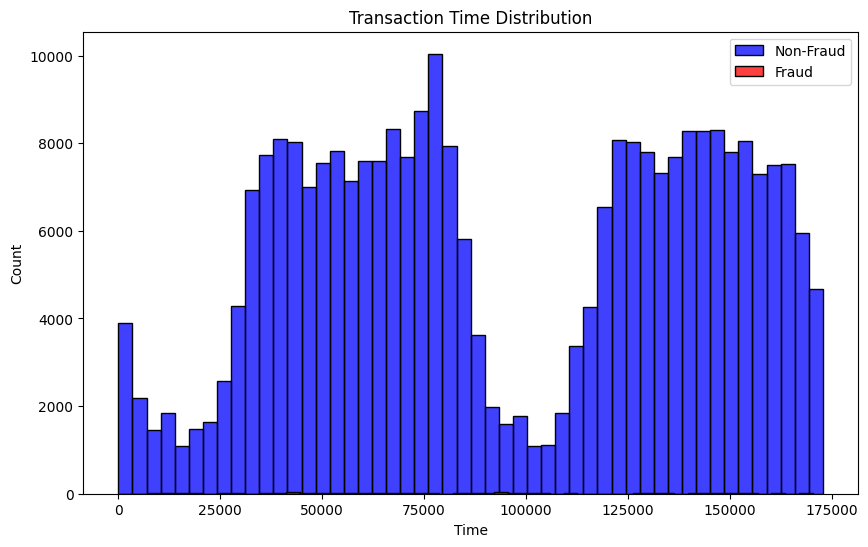

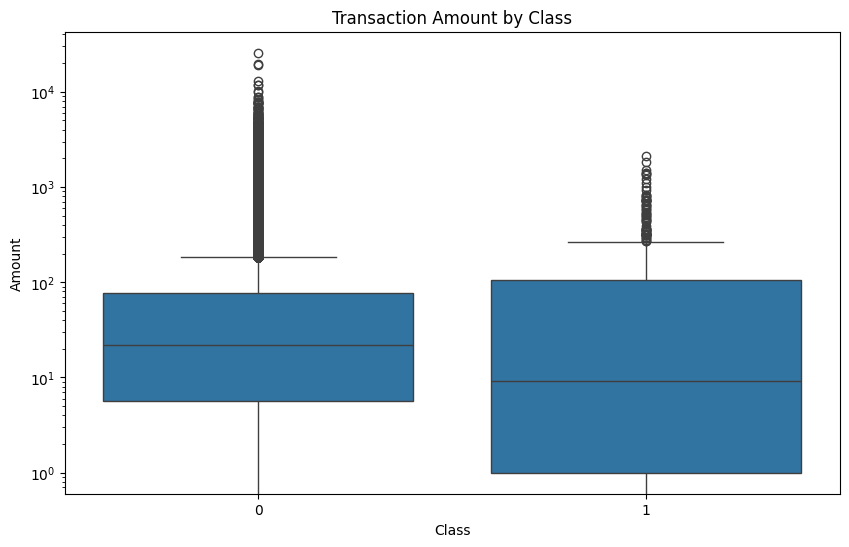

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fraud vs. Non-Fraud transaction time distribution
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Class'] == 0]['Time'], bins=50, color='blue', label='Non-Fraud')
sns.histplot(df[df['Class'] == 1]['Time'], bins=50, color='red', label='Fraud')
plt.legend()
plt.title("Transaction Time Distribution")
plt.show()

# Amount distribution (Log scale is important!)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.yscale('log')
plt.title("Transaction Amount by Class")
plt.show()

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 1. Log Transformation (Add +1 to avoid negative values)
df['Amount_Log'] = np.log1p(df['Amount'])  # log(1 + x)

# 2. Scaling (Apply StandardScaler after log transformation)
df['Amount_Log_Scaled'] = StandardScaler().fit_transform(df['Amount_Log'].values.reshape(-1, 1))
df['Time_Scaled'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))

print(df['Amount_Log_Scaled'])
print(df['Time_Scaled'])

# 3. Train-Test Split (Select columns with log transformation and scaling applied)
X = df.drop(['Class', 'Amount', 'Time', 'Amount_Log'], axis=1)  # Remove original columns
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

0         1.124303
1        -1.114639
2         1.682368
3         1.009339
4         0.670241
            ...   
284802   -1.558093
284803    0.059034
284804    0.652027
284805   -0.455313
284806    1.347486
Name: Amount_Log_Scaled, Length: 284807, dtype: float64
0        -1.996583
1        -1.996583
2        -1.996562
3        -1.996562
4        -1.996541
            ...   
284802    1.641931
284803    1.641952
284804    1.641974
284805    1.641974
284806    1.642058
Name: Time_Scaled, Length: 284807, dtype: float64


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Dictionary to store model performance results
results = {}

for name, model in models.items():
    model.fit(X_res, y_res)  # Fit the model on the balanced data from SMOTE
    y_pred = model.predict(X_test)  # Predict using the test data
    results[name] = y_pred  # Store predictions

In [9]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
import pandas as pd

# Create an empty DataFrame to store the metrics
metrics_df = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC'])

# Loop through each model and its corresponding predictions
for name, y_pred in results.items():
    # Generate the classification report, which includes precision, recall, f1-score
    report = classification_report(y_test, y_pred, output_dict=True)

    # Calculate ROC-AUC (Receiver Operating Characteristic Area Under the Curve)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Calculate PR-AUC (Precision-Recall Area Under the Curve)
    pr_auc = average_precision_score(y_test, y_pred)

    # Create a new row to add to the DataFrame
    new_row = pd.DataFrame({
        'Model': [name],
        'Precision': [report['1']['precision']],  # Precision for the positive class
        'Recall': [report['1']['recall']],        # Recall for the positive class
        'F1-Score': [report['1']['f1-score']],    # F1-Score for the positive class
        'ROC-AUC': [roc_auc],                     # ROC-AUC score
        'PR-AUC': [pr_auc]                        # PR-AUC score
    })

    # Append the new row to the metrics DataFrame using concat
    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

# Sort the results by Recall in descending order to prioritize models with better recall
metrics_df = metrics_df.sort_values(by='Recall', ascending=False)

# Print the final metrics DataFrame
print(metrics_df)

<ipython-input-9-2dce154c8917>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


                 Model  Precision    Recall  F1-Score   ROC-AUC    PR-AUC
0  Logistic Regression   0.053480  0.926471  0.101124  0.950165  0.049665
4    Gradient Boosting   0.108155  0.926471  0.193697  0.957146  0.100319
3                  SVM   0.085048  0.911765  0.155583  0.948064  0.077684
5  K-Nearest Neighbors   0.450185  0.897059  0.599509  0.947656  0.404006
1        Random Forest   0.866667  0.860294  0.863469  0.930042  0.745811
2              XGBoost   0.726708  0.860294  0.787879  0.929889  0.625405


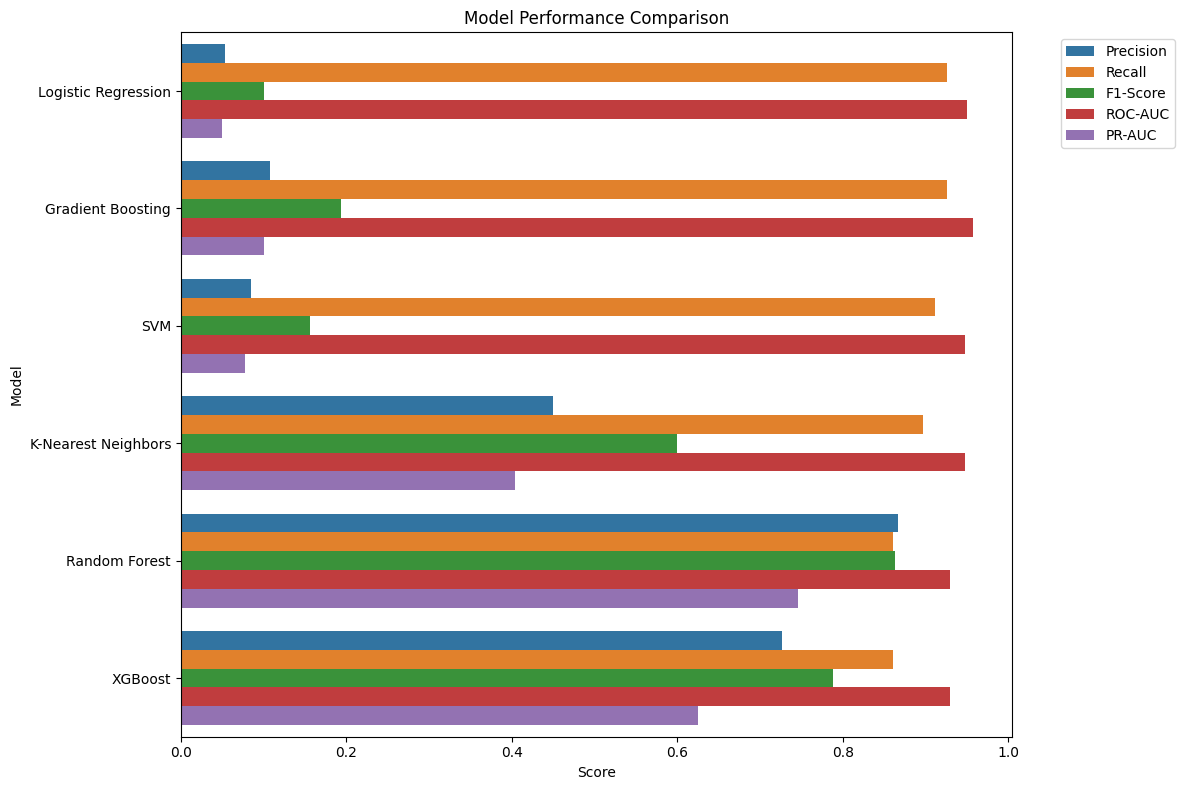

In [10]:
plt.figure(figsize=(12, 8))
metrics_df_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Value')
sns.barplot(x='Value', y='Model', hue='Metric', data=metrics_df_melted)
plt.title('Model Performance Comparison')
plt.xlabel('Score')
plt.ylabel('Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Random Forest için parametre grid'i
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

grid_search.fit(X_res, y_res)

print("En iyi parametreler:", grid_search.best_params_)
print("En iyi recall skoru:", grid_search.best_score_)